# Sampling Strategy Analysis for FIW Dataset

This notebook analyzes the sampling behavior of the KinshipBatchSampler with the FIWFamilyV3 dataset.

## Setup and Imports

In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from collections import Counter, defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from tqdm.auto import tqdm

# Add the parent directory to path
sys.path.append(str(Path.cwd().parent))

from datasets.scl import SCLDataModule  # noqa

## Load Dataset

In [3]:
# Initialize dataset
dm = SCLDataModule(
    dataset="ff-v3", batch_size=64, root_dir="../data/fiw/track1", sampler_verbose=True  # Adjust path as needed
)
dm.setup("fit")

# Get the dataset and sampler
dataset = dm.train_dataset
sampler = dm.train_dataloader().batch_sampler

Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 15310 unique persons
Loading samples from txt/val_choose_A.txt
Loaded 4988 samples from txt/val_choose_A.txt
Setup fit datasets
Initializing KinshipBatchSampler with batch_size=64, balance_families=False, balance_relationships=False


## Initial Dataset Statistics

In [4]:
# Count unique individuals
n_individuals = len(dataset.people)
print(f"Number of unique individuals: {n_individuals}")

# Count relationships per family
relationships_per_family = {fid: len(rel_indices) for fid, rel_indices in dataset.fam2rel.items()}
print(f"\nNumber of families: {len(relationships_per_family)}")
print(f"Average relationships per family: {sum(relationships_per_family.values()) / len(relationships_per_family):.2f}")

# Count relationship types
relationship_types = Counter(labels[4] for _, _, labels in dataset.relationships)
print("\nRelationship type distribution:")
for rel_type, count in relationship_types.items():
    print(f"{rel_type}: {count}")

Number of unique individuals: 15310

Number of families: 571
Average relationships per family: 8.37

Relationship type distribution:
fs: 715
sibs: 686
md: 726
ms: 710
ss: 396
fd: 701
bb: 361
gmgd: 120
gfgd: 112
gmgs: 136
gfgs: 114


## Detailed Dataset Statistics

The co-occurrence matrix shows how frequently different relationship types appear together within the same family.
Here's how to interpret it:

1. **Basic Structure**:
- Each cell (i,j) shows how many families contain BOTH relationship type i AND relationship type j
- The diagonal (i,i) shows how many families have that relationship type at all
- The matrix is symmetric because co-occurrence is bidirectional

2. **Common Relationship Types**:
```
bb = brother-brother
ss = sister-sister
sibs = brother-sister
fs = father-son
fd = father-daughter
ms = mother-son
md = mother-daughter
gfgd = grandfather-granddaughter
gmgd = grandmother-granddaughter
gfgs = grandfather-grandson
gmgs = grandmother-grandson
```

3. **Expected Patterns**:
- Parent-child relationships (fs, fd, ms, md) should commonly co-occur because
  families typically have multiple children
- Sibling relationships (bb, ss, sibs) should also frequently appear together
- Grandparent relationships might be less common overall

This analysis will help identify:

1. **Imbalanced Relationships**
  - If some relationship types are significantly over/under-represented

2. **Gender Biases**:
  - By comparing ratios of similar relationships across genders (e.g., father-son vs father-daughter)

3. **Missing Expected Patterns**:
  - For example, if families with fathers rarely have both sons and daughters

4. **Unusual Clusters**:
  - If certain relationship types co-occur more frequently than expected

5. **Data Quality Issues**:
  - Very low co-occurrence between naturally related relationships might indicate data collection problems

The analysis prints:
- Frequency of each relationship type
- Strongest co-occurrences (normalized by individual frequencies)
- Unexpected absences of common family patterns
- Gender balance metrics

This can help identify both dataset biases and potential data quality issues
that might affect your model's performance.

In [5]:
def compute_relationship_cooccurrence(dataset, rel_types_per_family):
    """Compute co-occurrence matrix of relationship types across families.

    Args:
        dataset: The dataset containing relationships
        rel_types_per_family: Dict mapping family IDs to their relationship
            type counts

    Returns:
        tuple: (relationship types list, co-occurrence matrix)
    """
    rel_types = list(set(labels[4] for _, _, labels in dataset.relationships))
    cooccurrence = np.zeros((len(rel_types), len(rel_types)))

    for types in rel_types_per_family.values():
        present_types = list(types.keys())
        for i, type1 in enumerate(rel_types):
            for j, type2 in enumerate(rel_types):
                if type1 in present_types and type2 in present_types:
                    cooccurrence[i, j] += 1

    return rel_types, cooccurrence


def compute_family_relationships(dataset):
    """Compute relationship counts and types per family.

    Args:
        dataset: The dataset containing relationships

    Returns:
        tuple: (rel_per_family dict mapping family ID to relationship count,
                rel_types_per_family dict mapping family ID to relationship type counts)
    """
    rel_per_family = {fid: len(rel_indices) for fid, rel_indices in dataset.fam2rel.items()}

    rel_types_per_family = defaultdict(lambda: defaultdict(int))
    for fid, rel_indices in dataset.fam2rel.items():
        for idx in rel_indices:
            rel_type = dataset.relationships[idx][2][4]  # Get relationship type
            rel_types_per_family[fid][rel_type] += 1

    return rel_per_family, rel_types_per_family


def analyze_dataset_structure(dataset):
    # Relationship distribution per family
    rel_per_family, rel_types_per_family = compute_family_relationships(dataset)

    # Calculate statistics
    print("=== Family Statistics ===")
    n_rels = np.array(list(rel_per_family.values()))
    print("\nRelationships per family:")
    print(f"Mean: {n_rels.mean():.2f}")
    print(f"Median: {np.median(n_rels):.2f}")
    print(f"Std: {n_rels.std():.2f}")
    print(f"Skewness: {stats.skew(n_rels):.2f}")
    print(f"Kurtosis: {stats.kurtosis(n_rels):.2f}")
    print(f"Min: {n_rels.min()}")
    print(f"Max: {n_rels.max()}")

    # Visualize relationship distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(n_rels, bins=50)
    plt.title("Distribution of Relationships per Family")
    plt.xlabel("Number of Relationships")
    plt.ylabel("Number of Families")
    plt.show()

    # Relationship type diversity per family
    rel_type_diversity = [len(types) for types in rel_types_per_family.values()]
    print("\n=== Relationship Type Diversity ===")
    print(f"Average number of different relationship types per family: {np.mean(rel_type_diversity):.2f}")
    print(f"Median number of different relationship types per family: {np.median(rel_type_diversity):.2f}")

    # Visualize relationship type diversity
    plt.figure(figsize=(10, 6))
    sns.histplot(rel_type_diversity, bins=range(min(rel_type_diversity), max(rel_type_diversity) + 2))
    plt.title("Distribution of Relationship Type Diversity per Family")
    plt.xlabel("Number of Different Relationship Types")
    plt.ylabel("Number of Families")
    plt.show()

    # Analyze co-occurrence of relationship types
    print("\n=== Relationship Type Co-occurrence ===")

    rel_types, cooccurrence = compute_relationship_cooccurrence(dataset, rel_types_per_family)

    # Plot co-occurrence heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(cooccurrence, xticklabels=rel_types, yticklabels=rel_types, annot=True, fmt="g", cmap="YlOrRd")
    plt.title("Relationship Type Co-occurrence Matrix")
    plt.tight_layout()
    plt.show()

    # People per family statistics
    people_per_family = defaultdict(set)
    for rel_idx, rel in enumerate(dataset.relationships):
        fid = rel[2][2]  # Family ID
        mid1, mid2 = rel[2][:2]  # Member IDs
        people_per_family[fid].add(mid1)
        people_per_family[fid].add(mid2)

    n_people = np.array([len(members) for members in people_per_family.values()])
    print("\n=== People per Family Statistics ===")
    print(f"Mean: {n_people.mean():.2f}")
    print(f"Median: {np.median(n_people):.2f}")
    print(f"Std: {n_people.std():.2f}")
    print(f"Min: {n_people.min()}")
    print(f"Max: {n_people.max()}")

    # Visualize people per family distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(n_people, bins=30)
    plt.title("Distribution of People per Family")
    plt.xlabel("Number of People")
    plt.ylabel("Number of Families")
    plt.show()

Analyzing dataset structure...
=== Family Statistics ===

Relationships per family:
Mean: 8.37
Median: 6.00
Std: 7.26
Skewness: 2.60
Kurtosis: 10.31
Min: 1
Max: 57


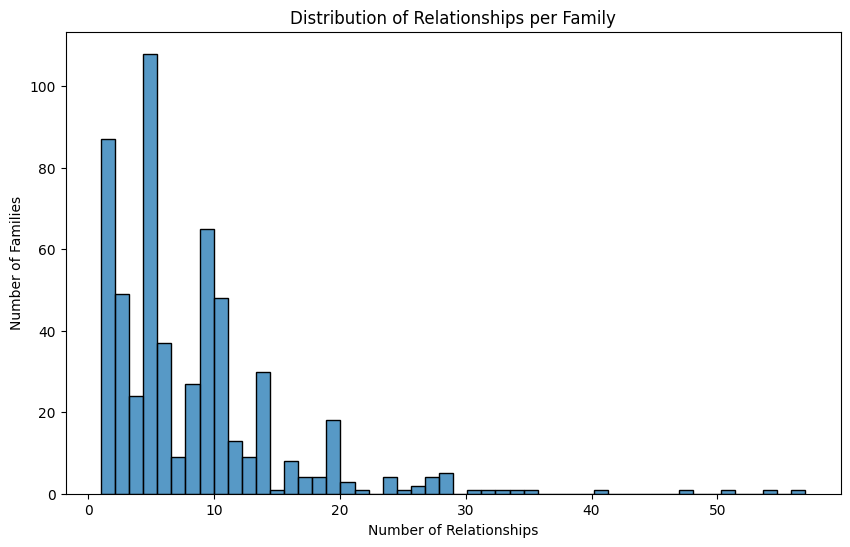


=== Relationship Type Diversity ===
Average number of different relationship types per family: 4.54
Median number of different relationship types per family: 5.00


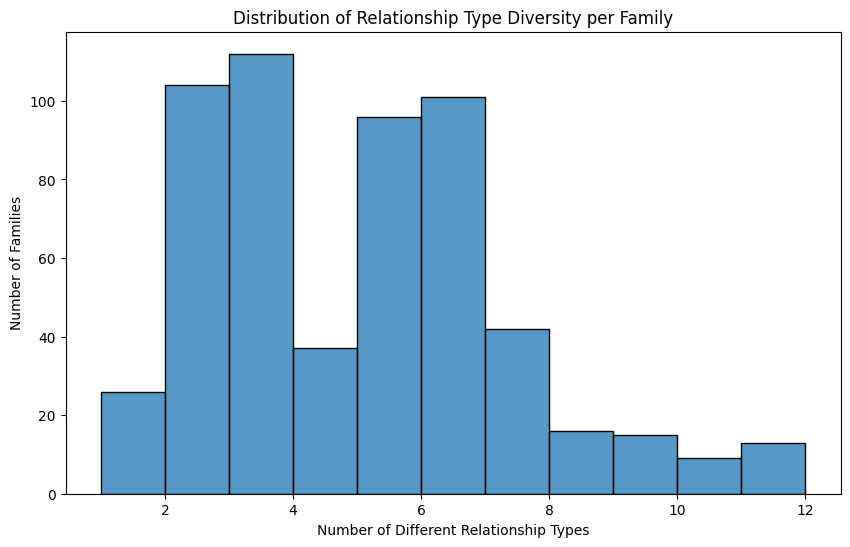


=== Relationship Type Co-occurrence ===


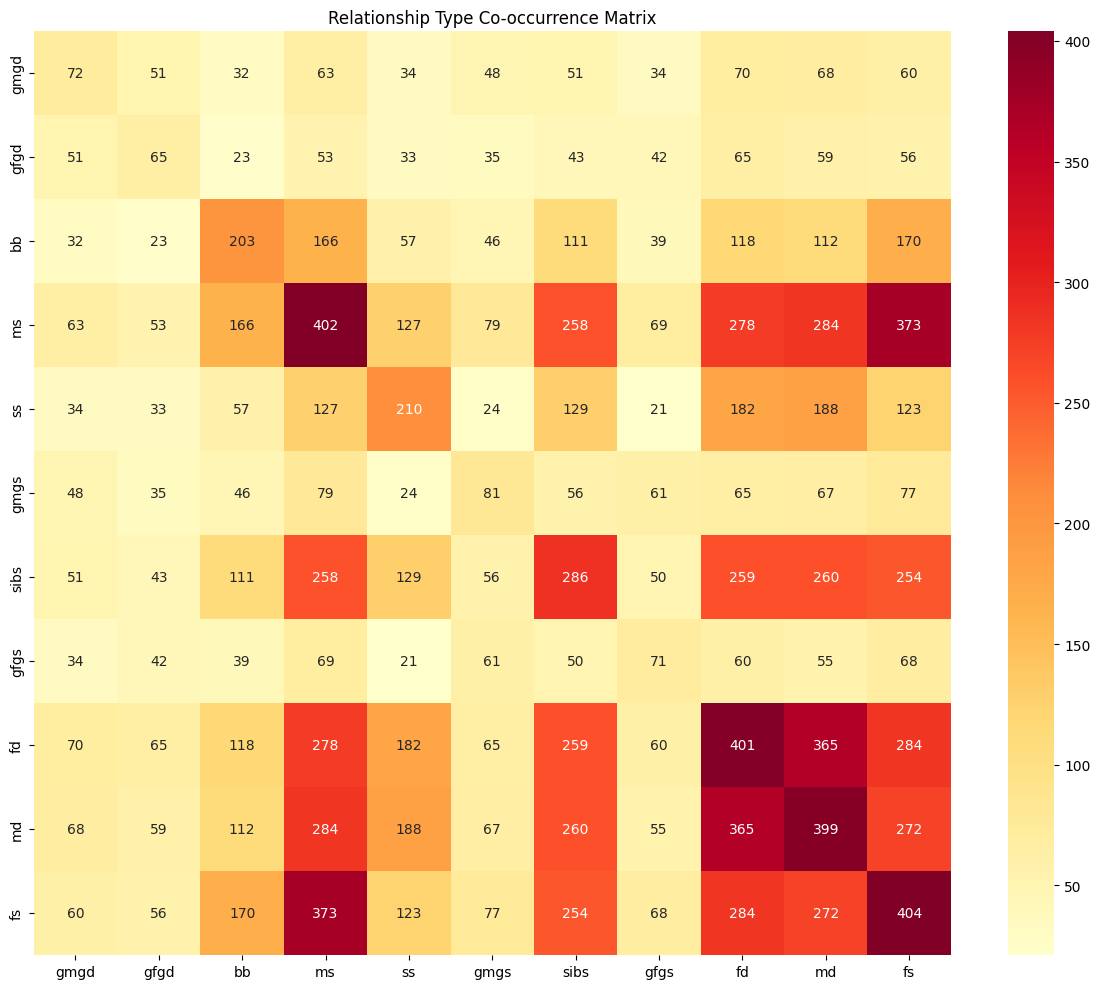


=== People per Family Statistics ===
Mean: 5.12
Median: 5.00
Std: 2.28
Min: 2
Max: 23


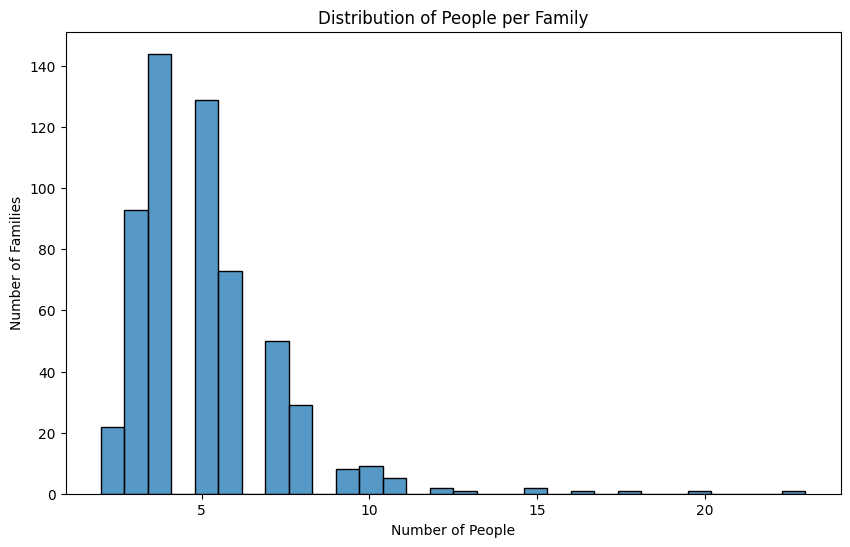

In [6]:
# Run the analysis
print("Analyzing dataset structure...")
analyze_dataset_structure(dataset)

In [7]:
def analyze_cooccurrence_patterns(cooccurrence, rel_types):
    total_families = cooccurrence.max()  # Assuming diagonal has highest values

    print("=== Co-occurrence Analysis ===")

    # Analyze diagonal (relationship frequency)
    print("\nRelationship Frequency (% of families):")
    for i, rel_type in enumerate(rel_types):
        percentage = (cooccurrence[i, i] / total_families) * 100
        print(f"{rel_type}: {percentage:.1f}%")

    # Find strongest co-occurrences
    print("\nStrongest Co-occurrences:")
    pairs = []
    for i in range(len(rel_types)):
        for j in range(i + 1, len(rel_types)):  # Upper triangle only
            if i != j:  # Skip diagonal
                strength = cooccurrence[i, j] / min(cooccurrence[i, i], cooccurrence[j, j])
                pairs.append((rel_types[i], rel_types[j], strength))

    # Sort by strength and print top 5
    pairs.sort(key=lambda x: x[2], reverse=True)
    for rel1, rel2, strength in pairs[:5]:
        print(f"{rel1}-{rel2}: {strength:.2f}")

    # Find unusual absences
    print("\nUnusual Absences (expected co-occurrences that are rare):")
    expected_pairs = [
        ("fs", "fd"),  # Fathers usually have both sons and daughters
        ("ms", "md"),  # Mothers usually have both sons and daughters
        ("bb", "sibs"),  # Brothers usually have sisters
        ("ss", "sibs"),  # Sisters usually have brothers
    ]

    for rel1, rel2 in expected_pairs:
        i, j = rel_types.index(rel1), rel_types.index(rel2)
        ratio = cooccurrence[i, j] / min(cooccurrence[i, i], cooccurrence[j, j])
        if ratio < 0.5:  # Arbitrary threshold
            print(f"{rel1}-{rel2}: {ratio:.2f}")

    # Check for gender imbalances
    print("\nGender Balance Analysis:")
    gender_pairs = [
        (("fs", "fd"), "father-child"),
        (("ms", "md"), "mother-child"),
        (("bb", "ss"), "siblings"),
        (("gfgs", "gfgd"), "grandfather-grandchild"),
        (("gmgs", "gmgd"), "grandmother-grandchild"),
    ]

    for (rel1, rel2), relation_type in gender_pairs:
        i, j = rel_types.index(rel1), rel_types.index(rel2)
        ratio = cooccurrence[i, i] / cooccurrence[j, j]
        print(f"{relation_type}: {ratio:.2f} ({rel1}/{rel2})")

In [8]:
rel_per_family, rel_types_per_family = compute_family_relationships(dataset)
rel_types, cooccurrence = compute_relationship_cooccurrence(dataset, rel_types_per_family)
analyze_cooccurrence_patterns(cooccurrence, rel_types)

=== Co-occurrence Analysis ===

Relationship Frequency (% of families):
gmgd: 17.8%
gfgd: 16.1%
bb: 50.2%
ms: 99.5%
ss: 52.0%
gmgs: 20.0%
sibs: 70.8%
gfgs: 17.6%
fd: 99.3%
md: 98.8%
fs: 100.0%

Strongest Co-occurrences:
gfgd-fd: 1.00
ms-gmgs: 0.98
gmgd-fd: 0.97
ms-gfgs: 0.97
gfgs-fs: 0.96

Unusual Absences (expected co-occurrences that are rare):

Gender Balance Analysis:
father-child: 1.01 (fs/fd)
mother-child: 1.01 (ms/md)
siblings: 0.97 (bb/ss)
grandfather-grandchild: 1.09 (gfgs/gfgd)
grandmother-grandchild: 1.12 (gmgs/gmgd)


## Sampling Analysis

Let's analyze how the sampler selects individuals and relationships over one epoch.

In [9]:
def analyze_epoch_sampling(sampler):
    # Counters for tracking
    individual_counts = Counter()
    relationship_type_counts = Counter()
    family_counts = Counter()

    # Iterate through one epoch
    for batch in tqdm(sampler, desc="Analyzing batches"):
        # Each batch is a list of tuples (img1_id, img2_id, labels)
        for item in batch[0]:
            img1_id, img2_id, labels = item
            # Track individuals
            individual_counts[img1_id] += 1
            individual_counts[img2_id] += 1

            # Track relationship types (labels[4] is kin_relation)
            relationship_type_counts[labels[4]] += 1

            # Track families (labels[2] is family ID)
            family_counts[labels[2]] += 1

    return individual_counts, relationship_type_counts, family_counts

## Visualization of Results

In [10]:
def visualize_sampling_results(individual_counts, relationship_type_counts, family_counts, title_prefix=""):
    """Plot distributions for individuals, relationships, and families."""
    # Individual sampling distribution
    plt.figure(figsize=(12, 6))
    plt.hist(list(individual_counts.values()), bins=50)
    plt.title(f"{title_prefix}Distribution of Individual Sampling Frequencies")
    plt.xlabel("Times Sampled")
    plt.ylabel("Number of Individuals")
    plt.show()

    # Relationship type distribution with specified order
    plt.figure(figsize=(12, 6))
    ordered_rel_types = ["bb", "ss", "sibs", "fs", "fd", "ms", "md", "gfgd", "gmgd", "gfgs", "gmgs"]
    rel_counts = [relationship_type_counts.get(rel, 0) for rel in ordered_rel_types]
    plt.bar(ordered_rel_types, rel_counts)
    plt.title(f"{title_prefix}Distribution of Relationship Types in Sampled Pairs")
    plt.xticks(rotation=45)
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()

    # Family sampling distribution
    plt.figure(figsize=(12, 6))
    plt.hist(list(family_counts.values()), bins=50)
    plt.title(f"{title_prefix}Distribution of Family Sampling Frequencies")
    plt.xlabel("Times Sampled")
    plt.ylabel("Number of Families")
    plt.show()


def calculate_cv(counts):
    values = np.array(list(counts.values()))
    return np.std(values) / np.mean(values) * 100


def print_sampling_statistics(individual_counts, relationship_type_counts, family_counts):
    """Print statistical analysis of sampling results."""
    # Individual sampling statistics
    total_samples = sum(individual_counts.values())
    unique_sampled = len(individual_counts)
    mean_samples = total_samples / unique_sampled
    max_samples = max(individual_counts.values())
    min_samples = min(individual_counts.values())

    print("Individual Sampling Statistics:")
    print(f"Total samples: {total_samples}")
    print(f"Unique individuals sampled: {unique_sampled}")
    print(f"Mean samples per individual: {mean_samples:.2f}")
    print(f"Max samples for one individual: {max_samples}")
    print(f"Min samples for one individual: {min_samples}")
    print(f"Sampling range (max/min): {max_samples/min_samples:.2f}")

    # Relationship type statistics
    print("\nRelationship Type Statistics:")
    for rel_type, count in relationship_type_counts.most_common():
        percentage = (count / sum(relationship_type_counts.values())) * 100
        print(f"{rel_type}: {count} ({percentage:.1f}%)")

    # Family sampling statistics
    print("\nFamily Sampling Statistics:")
    print(f"Total families sampled: {len(family_counts)}")
    print(f"Mean samples per family: {sum(family_counts.values()) / len(family_counts):.2f}")
    print(f"Max samples for one family: {max(family_counts.values())}")
    print(f"Min samples for one family: {min(family_counts.values())}")

    # Calculate and print CV
    rel_cv = calculate_cv(relationship_type_counts)
    fam_cv = calculate_cv(family_counts)
    print("\nCoefficient of Variation:")
    print(f"Relationship Types: {rel_cv:.1f}%")
    print(f"Family Sampling: {fam_cv:.1f}%")

## Original Sampling Analysis

Original Sampling Analysis:
Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 15310 unique persons
Loading samples from txt/val_choose_A.txt
Loaded 4988 samples from txt/val_choose_A.txt
Setup fit datasets


Analyzing batches:   0%|          | 0/74 [00:00<?, ?it/s]

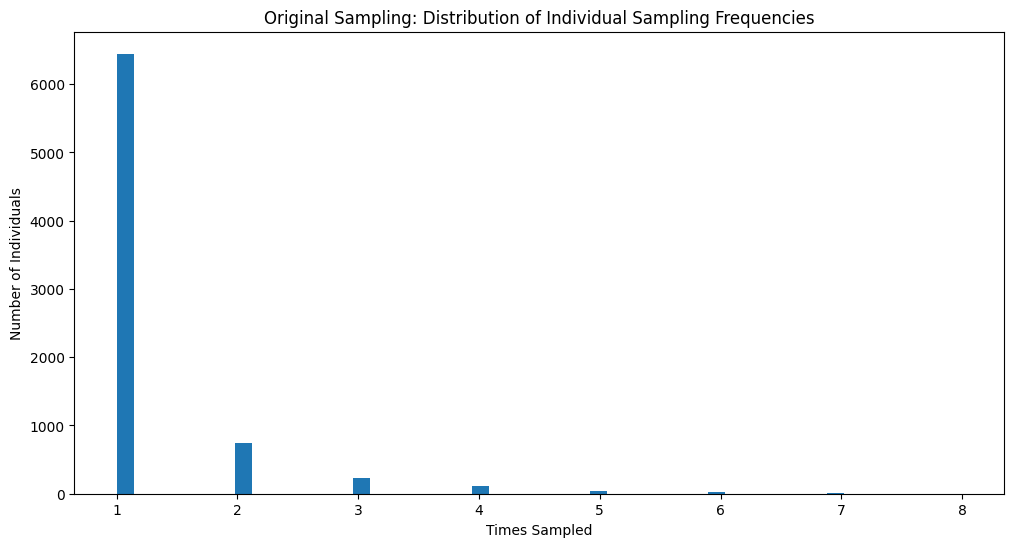

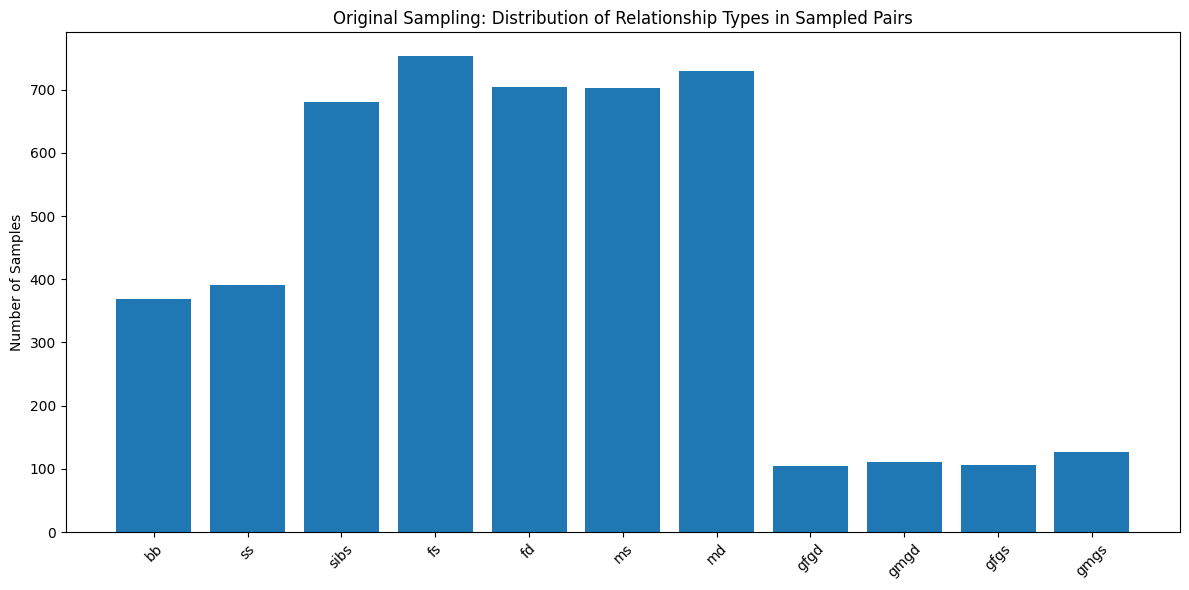

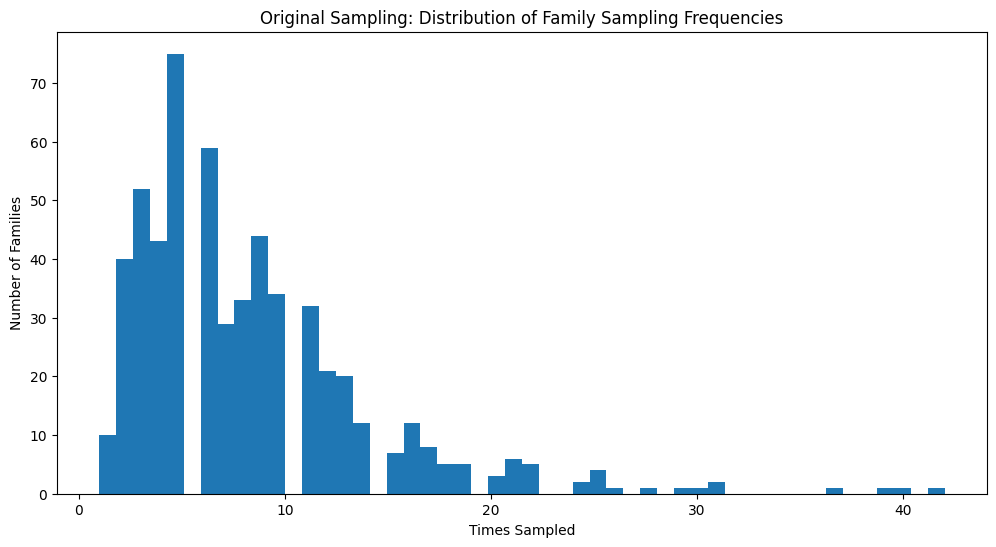

Individual Sampling Statistics:
Total samples: 9554
Unique individuals sampled: 7622
Mean samples per individual: 1.25
Max samples for one individual: 8
Min samples for one individual: 1
Sampling range (max/min): 8.00

Relationship Type Statistics:
fs: 753 (15.8%)
md: 730 (15.3%)
fd: 704 (14.7%)
ms: 702 (14.7%)
sibs: 680 (14.2%)
ss: 391 (8.2%)
bb: 369 (7.7%)
gmgs: 126 (2.6%)
gmgd: 111 (2.3%)
gfgs: 106 (2.2%)
gfgd: 105 (2.2%)

Family Sampling Statistics:
Total families sampled: 571
Mean samples per family: 8.37
Max samples for one family: 42
Min samples for one family: 1

Coefficient of Variation:
Relationship Types: 62.7%
Family Sampling: 71.0%


In [11]:
print("Original Sampling Analysis:")
dm = SCLDataModule(dataset="ff-v3", batch_size=64, root_dir="../data/fiw/track1", sampler_verbose=False)
dm.setup("fit")
sampler = dm.train_dataloader().batch_sampler
individual_counts, relationship_type_counts, family_counts = analyze_epoch_sampling(sampler)
visualize_sampling_results(individual_counts, relationship_type_counts, family_counts, "Original Sampling: ")
print_sampling_statistics(individual_counts, relationship_type_counts, family_counts)

## Balanced Sampling Analysis


Balanced Sampling Analysis:
Loading samples from txt/train_sort_A2_m.txt
Loaded 107185 samples from txt/train_sort_A2_m.txt
Found 571 unique fids
Generated 4777 relationships
Found 15310 unique persons
Loading samples from txt/val_choose_A.txt
Loaded 4988 samples from txt/val_choose_A.txt
Setup fit datasets
Initializing KinshipBatchSampler with batch_size=64, balance_families=True, balance_relationships=True


Analyzing batches:   0%|          | 0/74 [00:00<?, ?it/s]

Found 4 duplicate families in batch. Attempting replacement...
Found 570 eligible families for replacement
Replaced family 882 (relationship type: md) with family 680 (relationship type: gfgd) using balanced strategy
Found 570 eligible families for replacement
Replaced family 683 (relationship type: ss) with family 796 (relationship type: gmgd) using balanced strategy
Found 570 eligible families for replacement
Replaced family 73 (relationship type: sibs) with family 961 (relationship type: gmgs) using balanced strategy
Found 570 eligible families for replacement
Replaced family 326 (relationship type: sibs) with family 325 (relationship type: gfgd) using balanced strategy
Replacement complete. Remaining duplicates: 0
Found 7 duplicate families in batch. Attempting replacement...
Found 570 eligible families for replacement
Replaced family 796 (relationship type: fs) with family 690 (relationship type: gfgs) using balanced strategy
Found 570 eligible families for replacement
Replaced fa

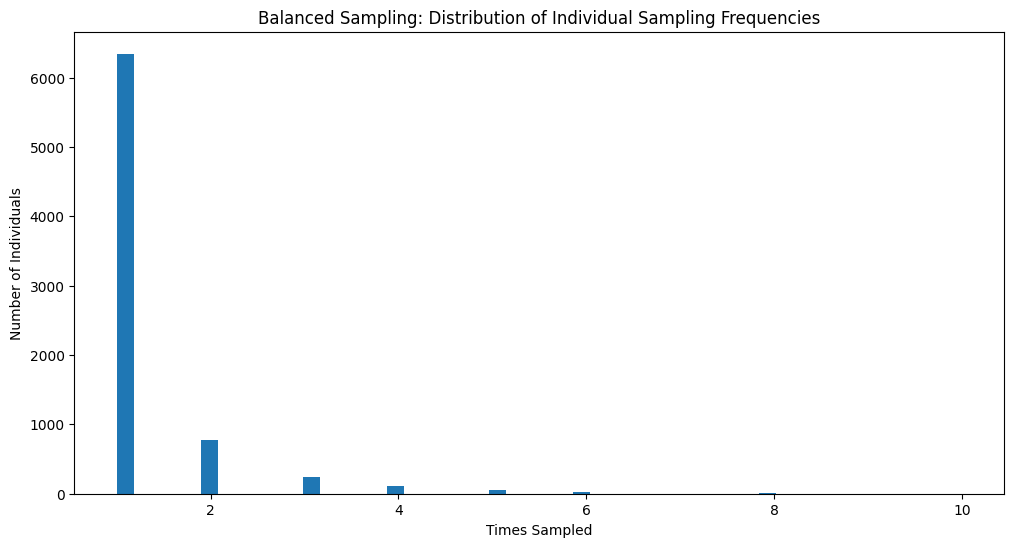

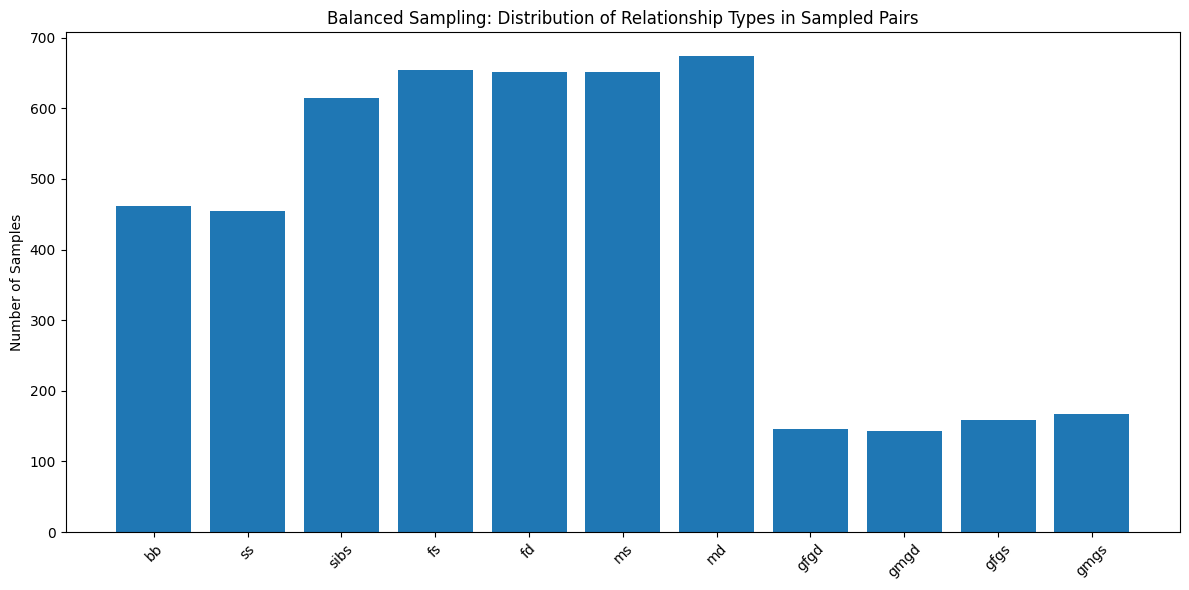

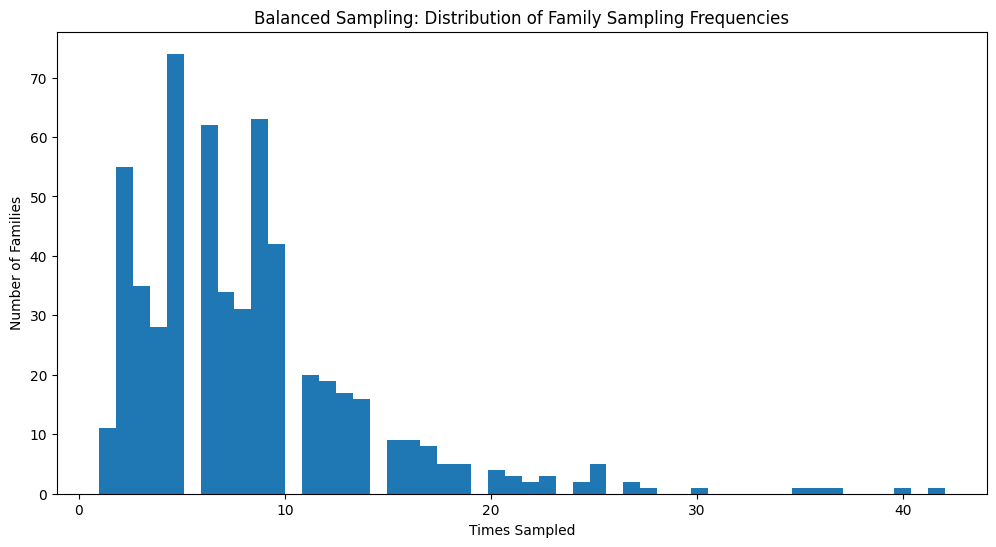

Individual Sampling Statistics:
Total samples: 9554
Unique individuals sampled: 7552
Mean samples per individual: 1.27
Max samples for one individual: 10
Min samples for one individual: 1
Sampling range (max/min): 10.00

Relationship Type Statistics:
md: 674 (14.1%)
fs: 655 (13.7%)
fd: 652 (13.6%)
ms: 651 (13.6%)
sibs: 615 (12.9%)
bb: 462 (9.7%)
ss: 454 (9.5%)
gmgs: 167 (3.5%)
gfgs: 158 (3.3%)
gfgd: 146 (3.1%)
gmgd: 143 (3.0%)

Family Sampling Statistics:
Total families sampled: 571
Mean samples per family: 8.37
Max samples for one family: 42
Min samples for one family: 1

Coefficient of Variation:
Relationship Types: 51.5%
Family Sampling: 69.8%


In [25]:
print("\nBalanced Sampling Analysis:")
dm = SCLDataModule(
    dataset="ff-v3",
    batch_size=64,
    root_dir="../data/fiw/track1",  # Adjust path as needed
    sampler_verbose=True,
    sampler_balance_families=True,
    sampler_balance_relationships=True,
    sampler_max_attempts=100,
    sampler_max_families=0,
)
dm.setup("fit")
sampler = dm.train_dataloader().batch_sampler
individual_counts, relationship_type_counts, family_counts = analyze_epoch_sampling(sampler)
visualize_sampling_results(individual_counts, relationship_type_counts, family_counts, "Balanced Sampling: ")
print_sampling_statistics(individual_counts, relationship_type_counts, family_counts)

## Understanding Coefficient of Variation (CV)

In [13]:
# What is CV?
# - Statistical measure of relative variability
# - Calculated as: `CV = (Standard Deviation / Mean) × 100%`
# - Expressed as a percentage
# - Allows comparison of variation across different scales
# - Lower values indicate more even distribution

## Current Results

### Relationship Types CV:
- Original: 64.1%
  - Parent-child relations: ~14.8-15.6%
  - Siblings: ~7.6-14.2%
  - Grandparents: ~2.1-2.5%
- Balanced: 51.4%
  - Parent-child relations: ~13.5-14.0%
  - Siblings: ~9.4-13.1%
  - Grandparents: ~3.1-3.5%

### Family Sampling CV:
- Original: 71.0%
  - Range: 1 to 44 samples/family
- Balanced: 69.4%
  - Range: 1 to 40 samples/family
  - Minor improvement

## Target CV Values

### Relationship Types:
- Ideal: < 15%
  - Would mean all types near ~9.1% (1/11)
- Realistic target: < 25%
  - Parent-child: ~10-12%
  - Siblings: ~8-10%
  - Grandparents: ~6-8%
- Current 51.4% is still too high

### Family Sampling:
- Ideal: < 25%
- Realistic target: < 40%
  - Constrained by:
    - Varying family sizes (2-23 people)
    - Different relationship availability (4.54 types/family)
    - Natural family structure
- Current 69.4% needs significant improvement

## Challenges
1. Relationship constraints:
  - Parent-child in ~99% of families
  - Grandparents in only ~17-20% of families
2. Family size variation:
  - Mean: 5.12 people
  - Range: 2-23 people
3. Trade-offs between:
  - Relationship balance
  - Family sampling
  - Individual/image usage

The balanced approach shows improvement but still needs work to reach target CVs.